In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
train_set = dset.MNIST(root='./data', train=True, transform=trans, download=True)
test_set = dset.MNIST(root='./data', train=False, transform=trans)
batch_size = 32


train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,shuffle=False)

In [3]:
class AlexNet(nn.Module):   
    def __init__(self, num=10):
        super(AlexNet, self).__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=1),
            nn.ReLU(inplace=True), 
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),   
            nn.MaxPool2d( kernel_size=2, stride=2),
            nn.Conv2d(64, 96, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),                         
            nn.Conv2d(96, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),                         
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d( kernel_size=2, stride=1),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(32*12*12,2048),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(2048,1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024,num),
         
        )
    
    def forward(self, x):

        x = self.feature(x)
        x = x.view(-1,32*12*12)
        x = self.classifier(x)
        return x
    

In [4]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
#         loss = F.nll_loss(output, target)
        loss = F.cross_entropy(output, target)
        train_losses.append(loss.data[0])
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('\rEpoch: {} {:.0f}%\t     Loss: {:.6f}'.format(
                epoch,
                100. * batch_idx / len(train_loader), loss.data[0]), end='')

In [7]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).data[0]
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()
    
    
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    acc=100. * float(correct.to(torch.device('cpu')).numpy())
    print('\nTest result: Average loss: {:.4f}, Accuracy: {:.4f}%\n'.format(
        test_loss, acc / len(test_loader.dataset)))
    
    test_accuracy.append(acc / len(test_loader.dataset))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 1 96%	     Loss: 2.288682

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # Remove the CWD from sys.path while we load stuff.



Test result: Average loss: 2.3006, Accuracy: 11.3500%

Epoch: 2 96%	     Loss: 2.296522
Test result: Average loss: 2.2981, Accuracy: 11.3500%

Epoch: 3 96%	     Loss: 0.445068
Test result: Average loss: 0.3044, Accuracy: 89.9500%

Epoch: 4 96%	     Loss: 0.020394
Test result: Average loss: 0.0865, Accuracy: 97.0200%

Epoch: 5 96%	     Loss: 0.123285
Test result: Average loss: 0.0548, Accuracy: 97.9800%

Epoch: 6 96%	     Loss: 0.041055
Test result: Average loss: 0.0441, Accuracy: 98.4200%

Epoch: 7 96%	     Loss: 0.146864
Test result: Average loss: 0.0377, Accuracy: 98.7700%

Epoch: 8 96%	     Loss: 0.117834
Test result: Average loss: 0.0358, Accuracy: 98.7900%

Epoch: 9 96%	     Loss: 0.027513
Test result: Average loss: 0.0308, Accuracy: 98.9300%

Epoch: 10 96%	     Loss: 0.008450
Test result: Average loss: 0.0295, Accuracy: 99.0200%

Epoch: 11 96%	     Loss: 0.059050
Test result: Average loss: 0.0272, Accuracy: 99.1200%

Epoch: 12 96%	     Loss: 0.034259
Test result: Average loss: 0

Text(0,0.5,'percent')

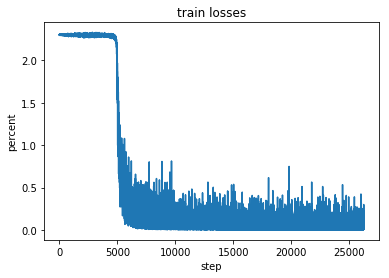

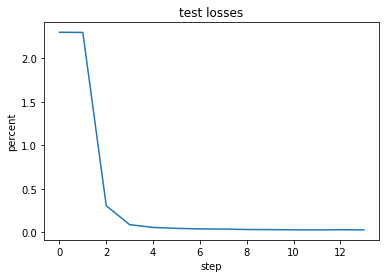

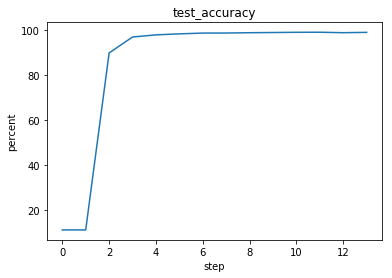

In [13]:
model = AlexNet()
if torch.cuda.is_available():
    model.cuda()
        
optimizer = optim.SGD(model.parameters(), lr=0.01)


train_losses = []
test_losses =[]
test_accuracy = []
for epoch in range(1, 15):
    train(epoch)
    test()
plt.figure()
plt.plot(train_losses)
plt.title('train losses')
plt.xlabel('step')
plt.ylabel('percent')

plt.figure()
plt.plot(test_losses)
plt.title('test losses')
plt.xlabel('step')
plt.ylabel('percent')

plt.figure()
plt.plot(test_accuracy)
plt.title('test_accuracy')
plt.xlabel('step')
plt.ylabel('percent')
    
    